In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import src.solver_helper as helper
from src.traffic_world import TrafficWorld
from src.car_plotting_multiple import plot_multiple_cars, plot_cars, animate

In [2]:
params = {}
params["T"] = 3
params["dt"] = 0.2
params["p_exec"] = 0.4
params["n_lanes"] = 2
params["n_other"] = 4
params["car_density"] = 5000
params["seed"] = 1
params["random_svo"] = 1

i_mpc_start = 0
params["N"] = max(1, int(params["T"] / params["dt"]))

params["number_ctrl_pts_executed"] = max(1, int(np.floor(params["N"] * params["p_exec"])))

### Create the world and vehicle objects
world = TrafficWorld(params["n_lanes"], 0, 999999)

### Create the vehicle placement based on a Poisson distribution
MAX_VELOCITY = 25 * 0.447  # m/s
VEHICLE_LENGTH = 4.5  # m
time_duration_s = (params["n_other"] * 3600.0 /
                   params["car_density"]) * 10  # amount of time to generate traffic
initial_vehicle_positions = helper.poission_positions(params["car_density"],
                                                      int(time_duration_s),
                                                      params["n_lanes"],
                                                      MAX_VELOCITY,
                                                      VEHICLE_LENGTH,
                                                      position_random_seed=params["seed"])
position_list = initial_vehicle_positions[:params["n_other"]]

### Create the SVOs for each vehicle
if params["random_svo"] == 1:
    list_of_svo = [np.random.choice([0, np.pi / 4.0, np.pi / 2.01]) for i in range(params["n_other"])]
else:
    list_of_svo = [params["svo_theta"] for i in range(params["n_other"])]

(ambulance, amb_x0, all_other_vehicles,
 all_other_x0) = helper.initialize_cars_from_positions(params["N"], params["dt"], world, True, position_list,
                                                       list_of_svo)


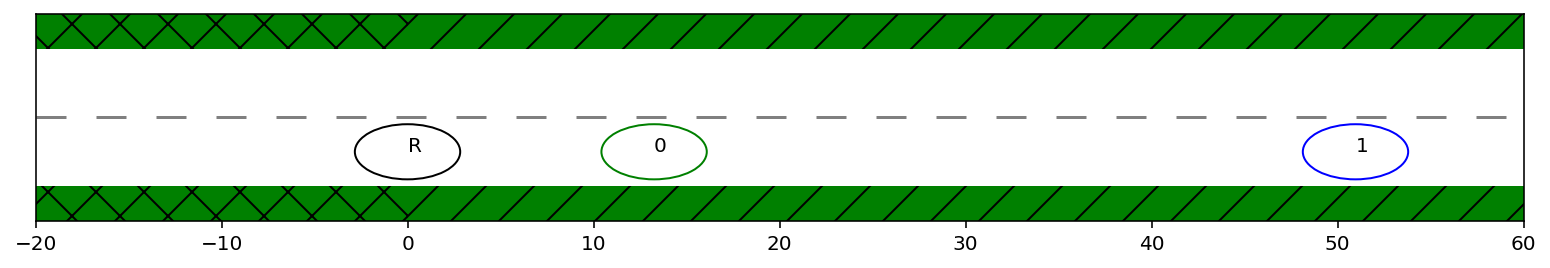

In [3]:
plot_multiple_cars(0, world, ambulance, amb_x0.reshape(6,1), [x.reshape(6,1) for x in all_other_x0], 
          None, car_labels = [str(i) for i in range(len(all_other_x0))])
plt.show()

In [4]:
for i in range(len(all_other_x0)):
    print(i, all_other_x0[i][0:2], )

0 [13.25666717  0.        ]
1 [50.96625915  0.        ]
2 [71.54523846  3.7       ]
3 [81.20876602  0.        ]


In [5]:
lead_veh = helper.get_lead_vehicle(amb_x0, all_other_x0, world)
if lead_veh is None:
    print("Veh Amb, Lead: None")
else:
    print("Veh Amb, Lead %d"%(lead_veh))
for i in range(len(all_other_x0)):
    dummy_x0 = all_other_x0[i] - 10000
    ado_x0s = all_other_x0[:i] + [dummy_x0] + all_other_x0[i+1:]  + [amb_x0]
    lead_veh = helper.get_lead_vehicle(all_other_x0[i], ado_x0s, world)
    if lead_veh is None:
        print("Veh %d, Lead: None"%(i))
    else:
        print("Veh %d, Lead %d"%(i, lead_veh))


Veh Amb, Lead 0
Veh 0, Lead 1
Veh 1, Lead 3
Veh 2, Lead: None
Veh 3, Lead: None


In [ ]:
N_total = 300
X_other = [np.zeros((6, N_total+1)) for i in range(len(all_other_vehicles))]
X_amb = np.zeros((6,N_total+1))

X_amb[:,0] = amb_x0
for i in range(len(X_other)):
    X_other[i][:,0] = all_other_x0[i]

    
idm_params = {
    "desired_time_gap": .2,
    "jam_distance": 0.5,
}
# idm_params = None

for t in range(N_total):
    current_other_x0 = [X_other[i][:,t] for i in range(len(X_other))]
    current_amb_x0 = X_amb[:,t]
#     print("Current other:", current_other_x0)
#     print("Current amb:", current_amb_x0)

    # Mobile lane change
    driver_x0 = X_amb[:,t]
    driver_veh = ambulance
    all_other_x0 = current_other_x0
    MOBIL_params = {
        "politeness_factor": 0.1,
    }
    lane, accel = helper.MOBIL_lanechange(driver_x0, driver_veh, all_other_x0, all_other_veh, world, MOBIL_params, idm_params)
    if lane is not None:
#         if t==128:
#             raise Exception("Lane change at t=128")

        print("Lane change at t=%d"%t)
        new_y = world.get_lane_centerline_y(lane)
        X_amb[1,t] = new_y
    current_amb_x0 = X_amb[:, t]

    # Ambulance
    lead_veh = helper.get_lead_vehicle(current_amb_x0, current_other_x0, world)
    if lead_veh is None:
        x_lead = None
        v_lead = None
    else:
        x_lead = current_other_x0[lead_veh]
    X_0 = current_amb_x0
    N=10
    U_ego, X_ego, X_des = helper.IDM_trajectory_prediction(ambulance, N, X_0, x_lead, desired_speed=None, idm_params=idm_params)
    X_amb[:,t+1] = X_ego[:,1]
    

    
    print("Amb", X_amb[:,t+1])
    # Other vehicles
    for ego_idx in range(len(all_other_vehicles)):
        N = 1
                           
    
        # Mobile lane change
        driver_x0 = current_other_x0[ego_idx] 
        driver_veh = all_other_vehicles[ego_idx]
        all_other_x0 = current_other_x0[:ego_idx] + current_other_x0[ego_idx+1:]  + [current_amb_x0]   
        all_other_veh = all_other_vehicles[:ego_idx] + all_other_vehicles[ego_idx+1:]  + [ambulance]    
        
        MOBIL_params = {
            "politeness_factor": 0.1,
        }
        lane, accel = helper.MOBIL_lanechange(driver_x0, driver_veh, all_other_x0, all_other_veh, world, MOBIL_params, idm_params)
        if lane is not None:
            print("Lane change at t=%d"%t)
            new_y = world.get_lane_centerline_y(lane)
            X_other[ego_idx][1,t] = new_y
        current_other_x0[ego_idx] = X_other[ego_idx][:, t]        
        
        
        
        X_0 = current_other_x0[ego_idx]
        dummy_x0 = current_other_x0[ego_idx] - 10000
        ado_x0s = current_other_x0[:ego_idx] + [dummy_x0] + current_other_x0[ego_idx+1:]  + [current_amb_x0]
        lead_veh = helper.get_lead_vehicle(current_other_x0[ego_idx], ado_x0s, world)    

        if lead_veh is None:
            x_lead = None
            v_lead = None
        else:
            x_lead = ado_x0s[lead_veh]


        U_ego, X_ego, X_des = helper.IDM_trajectory_prediction(all_other_vehicles[ego_idx], N, X_0, x_lead, desired_speed=None, idm_params=idm_params)
        
        X_other[ego_idx][:,t+1] = X_ego[:, 1]
        
        

        
        
        
        
        
#         print(ego_idx, X_ego[:,1])

In [ ]:
temp_folder = "/home/nbuckman/mpc-multiple-vehicles/jupyter_notebooks/temp/"
plot_cars(world, ambulance, X_amb, X_other, temp_folder, "image")

In [ ]:
vid_fname = temp_folder + "MOBIL_Egoistic.mp4"
animate(temp_folder, vid_fname, fps=16)

In [ ]:
from IPython.display import Video

Video(vid_fname, embed=True, width=1024)

In [ ]:
plot_multiple_cars(0, world, ambulance, np.zeros((6,1)), [np.array([[6, 0,0,0,0,0]]).T], 
              None, car_plot_shape = 'both')
plt.show()

In [ ]:
plot_multiple_cars(0, world, ambulance, np.zeros((6,1)), [np.array([[ambulance.L, 0,0,0,0,0]]).T], 
              None, car_plot_shape = 'image')
plt.show()

In [ ]:
np.array([[6, 0,0,0,0,0]]).shape

In [ ]:
# driver_idx = 1
# driver_x0 = X_other[driver_idx][:,-1]
# driver_veh = all_other_vehicles[driver_idx]
# all_other_x0 = [X_other[idx][:,-1] for idx in range(1,len(X_other)) if idx!=driver_idx] + [amb_x0]
# all_other_veh = [all_other_vehicles[idx] for idx in range(1,len(X_other)) if idx!=driver_idx] + [ambulance]


In [ ]:
driver_x0 = X_amb[:, -1]
driver_veh = ambulance
all_other_x0 = [X_other[idx][:,-1] for idx in range(1,len(X_other))] 
all_other_veh = [all_other_vehicles[idx] for idx in range(1,len(X_other))]


In [ ]:
plot_multiple_cars(0, world, ambulance, driver_x0.reshape(6,1), [x.reshape(6,1) for x in all_other_x0], 
          None, car_labels = [str(i) for i in range(len(all_other_x0))])
plt.show()

In [ ]:

MOBIL_params = {}

lane, accel = helper.MOBIL_lanechange(driver_x0, driver_veh, all_other_x0, all_other_veh, world, MOBIL_params, idm_params)


In [ ]:
lane

In [ ]:
lane

In [ ]:
accel

In [ ]:
default_MOBIL_params = {
    "politeness_factor": 0.5,
    "changing_threshold": 0.1,
    "maximum_safe_deceleration": 4,
    "bias_for_right_lane": 0.3
}
if MOBIL_params:
    for param in MOBIL_params:
        try:
            default_MOBIL_params[param] = MOBIL_params[param]
        except KeyError:
            raise Exception("Key Error:  Check if MOBIL Param is correct")

p = default_MOBIL_params["politeness_factor"]
a_thr = default_MOBIL_params["changing_threshold"]
b_safe = default_MOBIL_params["maximum_safe_deceleration"]
a_bias = default_MOBIL_params["bias_for_right_lane"]


safety_criteria = accel["newfollower_after"] >= -b_safe

driver_incentive = accel["driver_after"] - accel["driver_before"]
new_follower_incentive = accel["newfollower_after"] - accel["newfollower_before"]
old_follower_incentive = accel["oldfollower_after"] - accel["oldfollower_before"]

incentive_criteria = (driver_incentive + p * (new_follower_incentive + old_follower_incentive)) >= (a_thr)

In [ ]:
driver_incentive

In [ ]:
((new_follower_incentive + old_follower_incentive)*p + driver_incentive >= a_thr)

In [ ]:
a_thr